In [1]:
import pandas as pd
import numpy as np

## Acquiring Data

Treinar o modelo apenas com as features que existirão nos dados a serem previstos.

In [2]:
test = pd.read_csv('test.csv')
features = test.columns

def load_train(train_path, features, target):
    train = pd.read_csv(train_path)    
    train_features = np.append(features, target)
    train = train.loc[:, train_features]
    return train

train = load_train('train.csv', features, 'IN_TREINEIRO')

In [3]:
train.shape, test.shape

((13730, 44), (4570, 43))

###  Analisando dados faltantes
Total relativo de dados faltantes em bases de treino e teste. 

In [4]:
def missing(dataframe, name='missing'):
    missing = dataframe.isnull().mean().sort_values(ascending=False).to_frame(name)
    return missing[missing.iloc[:, 0] > 0]

In [5]:
pd.concat([missing(test, 'test_missing'), missing(train, 'train_missing')], axis=1)

,test_missing,train_missing
TP_DEPENDENCIA_ADM_ESC,0.687965,0.688128
TP_ENSINO,0.687965,0.688128
Q027,0.533260,0.536999
NU_NOTA_COMP1,0.256018,0.261981
NU_NOTA_COMP5,0.256018,0.261981
TP_STATUS_REDACAO,0.256018,0.261981
NU_NOTA_COMP2,0.256018,0.261981
NU_NOTA_COMP3,0.256018,0.261981
NU_NOTA_COMP4,0.256018,0.261981
NU_NOTA_REDACAO,0.256018,0.261981


## Verificando o Balanceamento das Classes


In [6]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(12, 8)

Balanceamento das classes. Deixar a mesma quantidade de amostras para cada uma.

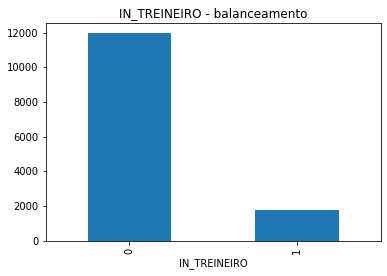

In [7]:
plt.title('IN_TREINEIRO - balanceamento')
train.groupby('IN_TREINEIRO')['IN_TREINEIRO'].count().plot(kind='bar');

## Helpers - preparando os dados
Aqui se encontram algumas funções para ajudar no tratamento dos dados. A seguir as funções 'pipeline' representam cada etapa da criação do modelo.

In [8]:
from sklearn.preprocessing import KBinsDiscretizer

def impute_grades_with_0(train, test):
    impute_grades = {
        'TP_PRESENCA_CN': ['NU_NOTA_CN'], 
        'TP_PRESENCA_CH': ['NU_NOTA_CH'], 
        'TP_PRESENCA_LC': [
            'NU_NOTA_LC', 
            'NU_NOTA_COMP1', 
            'NU_NOTA_COMP2', 
            'NU_NOTA_COMP3', 
            'NU_NOTA_COMP4', 
            'NU_NOTA_COMP5', 
            'NU_NOTA_REDACAO'
        ]
    }   
    for attendance, grades in impute_grades.items():
        train.loc[(train[attendance] != 1), grades] = 0
    
    for attendance, grades in impute_grades.items():
        test.loc[(test[attendance] != 1), grades] = 0
        
    # se faltou prova ficou em branco(4), se eliminado foi anulada (2)
    train.loc[train.TP_PRESENCA_LC == 2, 'TP_STATUS_REDACAO'] = 2
    train.loc[train.TP_PRESENCA_LC == 0, 'TP_STATUS_REDACAO'] = 4
    test.loc[train.TP_PRESENCA_LC == 2, 'TP_STATUS_REDACAO'] = 2
    test.loc[train.TP_PRESENCA_LC == 0, 'TP_STATUS_REDACAO'] = 4
    
def drop_eliminated_cn_ch(train):
    index = train[(train['TP_PRESENCA_CN'] == 2)  | (train['TP_PRESENCA_CH'] == 2)].index
    train.drop(index, axis=0, inplace=True)
    
def discretize_nu_idade(train, test):
    discretizer = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
    discretizer.fit(train[['NU_IDADE']])
    train['NU_IDADE'] = discretizer.transform(train[['NU_IDADE']]).astype(int)
    test['NU_IDADE'] = discretizer.transform(test[['NU_IDADE']]).astype(int)
    train['NU_IDADE'] = train['NU_IDADE'].astype('category')
    test['NU_IDADE'] = test['NU_IDADE'].astype('category')
        
def discard_features(train, test):
    to_discard = [
        # já existe CO_UF_RESIDENCIA
        'SG_UF_RESIDENCIA', 
        # só diz respeito a quem já concluiu (nem todos concluíram)
        'TP_ANO_CONCLUIU', 
        # features com missing data: a princípio serão excluídas do modelo
        'TP_ENSINO', 
        'TP_DEPENDENCIA_ADM_ESC',
        'Q027',
        # tem apenas uma classe (0)
        'IN_CEGUEIRA'
    ]
    train.drop(to_discard, inplace=True, axis=1)
    test.drop(to_discard, inplace=True, axis=1)   
        
def correct_dtypes(train, test):
    size = lambda x: round(x.memory_usage().sum() / (1024*1024), 3)        
    to_float = [it for it in test.columns.values if 'NU_NOTA' in it]    
    to_category = [it for it in test.columns.values if 'NU_' not in it] 
    
    size_before = (size(train), size(test))
    
    test[to_float] = test[to_float].astype(float)
    train[to_float] = train[to_float].astype(float)    
    test[to_category] = test[to_category].astype('category')
    train[to_category] = train[to_category].astype('category')        
    size_after = (size(train), size(test))    
    return size_before, size_after

def anova_selection(train):
    from AnovaTest import AnovaTest as tt
    anova_test = tt(train, train.columns).run()
    anova_test = pd.DataFrame(
        data=anova_test, 
        columns=['feature', 'F-score', 'P-value']
    ).set_index(
        'feature'
    ).sort_values('P-value', ascending=True)
    anova_test = anova_test[(anova_test['P-value'] < 0.001)].sort_values('F-score', ascending=False)
    return np.append(
        ['NU_INSCRICAO'],
        np.append(
            anova_test[(anova_test['P-value'] < 0.001)].sort_values('F-score', ascending=False).index.values,
            train.select_dtypes(include=float).columns
        )
    )

Esta função plota a matriz de confusão. Foi extraída do curso **Machine Learning**, via Cognitive Class, IBM.

In [9]:
import pylab as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
def pipeline_data_dealing(train, test):
    discard_features(train, test)
    impute_grades_with_0(train, test)
    drop_eliminated_cn_ch(train)
    discretize_nu_idade(train, test)
    correct_dtypes(train, test)

def pipeline_data_selection_anova(train, test):
    columns_anova = anova_selection(train)
    train = train.loc[:, np.append(columns_anova, 'IN_TREINEIRO')].copy() 
    test = test.loc[:, columns_anova].copy()
    return train, test
    
def pipeline_get_dummies(train, test):
    cat_columns = train.select_dtypes(include='category').columns
    if cat_columns.size:
        train = pd.concat([train, pd.get_dummies(train[cat_columns], drop_first=True)], axis=1)
        train.drop(cat_columns, axis=1, inplace=True)

        test = pd.concat([test, pd.get_dummies(test[cat_columns], drop_first=True)], axis=1)
        test.drop(cat_columns, axis=1, inplace=True)
    return train, test
        
def pipeline_data_selection_kbest(train, test):
    from sklearn.feature_selection import SelectKBest
    kbest = SelectKBest(k=30)
    kbest.fit(
        train.drop(['NU_INSCRICAO', 'IN_TREINEIRO'], axis=1), 
        train.loc[:, 'IN_TREINEIRO']
    )
    kbest_features = train.drop(['NU_INSCRICAO', 'IN_TREINEIRO'], axis=1).columns.values[kbest.get_support()]
    
    train = pd.concat([train.loc[:, 'NU_INSCRICAO'], train.loc[:, kbest_features], train.loc[:, 'IN_TREINEIRO']], axis=1)
    test = pd.concat([test.loc[:, 'NU_INSCRICAO'], test.loc[:, kbest_features]], axis=1)
    return train, test

def undersampling(train):
    n_sample = train.groupby('IN_TREINEIRO')['IN_TREINEIRO'].count().min()
    undersampled = train.groupby(
        'IN_TREINEIRO', group_keys=False
    ).apply(
        lambda x: x.sample(n=n_sample, random_state=42)
    )
    return undersampled
    
def oversampling(train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    x, y = sm.fit_sample(train.drop(['IN_TREINEIRO','NU_INSCRICAO'], axis=1), train.loc[:, 'IN_TREINEIRO'])
    return pd.concat([x, y], axis=1)

def pipeline_data_training_undersampling(train):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix, log_loss
    
    undersampled = undersampling(train)
    X = undersampled.drop(['NU_INSCRICAO', 'IN_TREINEIRO'], axis=1)
    y = undersampled.loc[:, 'IN_TREINEIRO']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train)
    
    yhat = LR.predict(x_test)
    yhat_prob = LR.predict_proba(x_test) 
    log_loss = log_loss(y_test, yhat_prob)
    cnf = confusion_matrix(y_test, yhat, labels=[1,0])
    return LR, {'yhat':yhat, 
                'proba':yhat_prob, 
                'log_loss':log_loss, 
                'confusion':cnf,
                'report':classification_report(y_test, yhat, output_dict=False)
               }

def pipeline_data_training_oversampling(train):
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix, log_loss
    
    oversampled = oversampling(train)
    X = oversampled.drop('IN_TREINEIRO', axis=1)
    y = oversampled.loc[:, 'IN_TREINEIRO']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train)
    
    yhat = LR.predict(x_test)
    yhat_prob = LR.predict_proba(x_test) 
    log_loss = log_loss(y_test, yhat_prob)
    cnf = confusion_matrix(y_test, yhat, labels=[1,0])
    return LR, {'yhat':yhat, 
                'proba':yhat_prob, 
                'log_loss':log_loss, 
                'confusion':cnf,
                'report':classification_report(y_test, yhat, output_dict=False)
               }

## Criando os Modelos

Serão criados dois modelos

### Testar duas técnicas para resolver o problema do desbalanceamento de classes:
 
 - Undersampling:
     - Reduzir a quantidade de amostras da classe dominante igualando sua quantidade de amostras à da classe menos frequente.
 - Oversampling
     - Gerar amostras sintéticas randômicas da classe menos frequente igualando sua quantidade de amostras à da classe mais frequente. 
     - Usar técnica SMOTE (Synthetic Minority Over-sampling Technique)

In [11]:
test = pd.read_csv('test.csv')
features = test.columns
train = load_train('train.csv', features, 'IN_TREINEIRO')

pipeline_data_dealing(train, test)
train, test = pipeline_data_selection_anova(train, test)
train, test = pipeline_get_dummies(train, test)
train, test = pipeline_data_selection_kbest(train, test)
model_undersampled, metrics_undersampled = pipeline_data_training_undersampling(train)
model_oversampled, metrics_oversampled = pipeline_data_training_oversampling(train)

## Avaliando os Modelos

### Matriz Confusão

In [12]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization


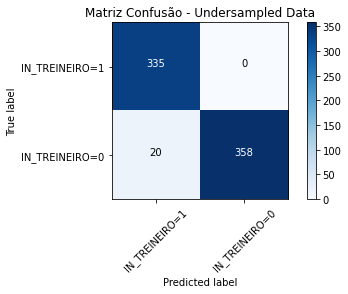

In [13]:
plt.figure()
plot_confusion_matrix(
    metrics_undersampled['confusion'], 
    classes=['IN_TREINEIRO=1','IN_TREINEIRO=0'],
    normalize= False,  
    title='Matriz Confusão - Undersampled Data'
)
plt.show()


Confusion matrix, without normalization


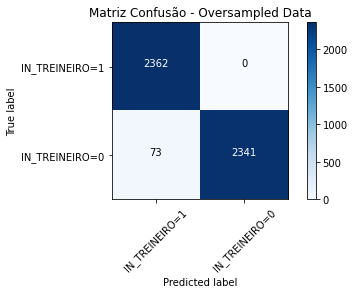

In [14]:
plt.figure()
plot_confusion_matrix(
    metrics_oversampled['confusion'], 
    classes=['IN_TREINEIRO=1','IN_TREINEIRO=0'],
    normalize= False,  
    title='Matriz Confusão - Oversampled Data'
)
plt.show()


### Relatório de Classificação

In [15]:
print('\n\nRelatório de Classificação - Undersampled Data: \n\n{}'.format(metrics_undersampled['report']))
print('\n\nRelatório de Classificação - Oversampled Data: \n\n{}'.format(metrics_oversampled['report']))



Relatório de Classificação - Undersampled Data: 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       378
           1       0.94      1.00      0.97       335

    accuracy                           0.97       713
   macro avg       0.97      0.97      0.97       713
weighted avg       0.97      0.97      0.97       713



Relatório de Classificação - Oversampled Data: 

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2414
           1       0.97      1.00      0.98      2362

    accuracy                           0.98      4776
   macro avg       0.99      0.98      0.98      4776
weighted avg       0.99      0.98      0.98      4776



### Log Loss

In [16]:
print('\n\nLog Loss - Undersampled Data: {}'.format(metrics_undersampled['log_loss']))
print('\n\nLog Loss - Oversampled Data: {}'.format(metrics_oversampled['log_loss']))



Log Loss - Undersampled Data: 0.2280240191161854


Log Loss - Oversampled Data: 0.08733337360010997


## Conclusão

O modelo que usou a técnica de oversampling teve melhor desempenho que o modelo que utilizou undersampling.

## Prevendo o conjunto de teste e submetendo o desafio

### Undersampled Model

In [17]:
teste_undersampled = test.copy()
teste_undersampled['IN_TREINEIRO'] = model_undersampled.predict(teste_undersampled.iloc[:, 1:])

In [18]:
teste_undersampled[['NU_INSCRICAO', 'IN_TREINEIRO']].to_csv('answer.csv')

In [19]:
! codenation submit -c enem-4

Versão: 1.0.14

Usando arquivo de configuração: /home/flavia/.codenation.yml

Executando testes...

{"score": 96.14879649890591}
Preparando code review... 100% |████████████████████████████████████████|  [5s:0s]
Códigos submetidos com sucesso! 

Sua nota é: 96.148796

Parabéns! Você superou este desafio!

O que fazer agora?
- Você pode continuar sua jornada escolhendo um novo desafio em https://www.codenation.com.br
- Você pode ajudar outros desenvolvedores revisando códigos ou respondendo dúvidas no forum do desafio
- Lembre-se que ensinar é uma ótima forma de ganhar reconhecimento e gera um bom karma ;)


### Oversampled Model

In [20]:
teste_oversampled = test.copy()
teste_oversampled['IN_TREINEIRO'] = model_oversampled.predict(teste_oversampled.iloc[:, 1:])

In [21]:
teste_oversampled[['NU_INSCRICAO', 'IN_TREINEIRO']].to_csv('answer.csv')

In [22]:
! codenation submit -c enem-4

Versão: 1.0.14

Usando arquivo de configuração: /home/flavia/.codenation.yml

Executando testes...

{"score": 97.13347921225383}
Preparando code review... 100% |████████████████████████████████████████|  [5s:0s]
Códigos submetidos com sucesso! 

Sua nota é: 97.133479

Parabéns! Você superou este desafio!

O que fazer agora?
- Você pode continuar sua jornada escolhendo um novo desafio em https://www.codenation.com.br
- Você pode ajudar outros desenvolvedores revisando códigos ou respondendo dúvidas no forum do desafio
- Lembre-se que ensinar é uma ótima forma de ganhar reconhecimento e gera um bom karma ;)
